In [579]:
import pandas as pd
import numpy as np
import re
import textstat
from textblob import TextBlob
import matplotlib.pyplot as plt
from langdetect import detect
import seaborn as sns

In [170]:
ratings_ba = pd.read_csv('../data/local/ratings_ba.csv', encoding="utf8")
ratings_ba

,beer_name,beer_id,date,user_name,user_id,overall,text
0,Régab,142544,1440064800,nmann08,nmann08.184925,3.0,"From a bottle, pours a piss yellow color with ..."
1,Barelegs Brew,19590,1235127600,StJamesGate,stjamesgate.163714,3.5,Pours pale copper with a thin head that quickl...
2,Barelegs Brew,19590,1142247600,mdagnew,mdagnew.19527,3.5,"500ml Bottle bought from The Vintage, Antrim....."
3,Barelegs Brew,19590,1101898800,helloloser12345,helloloser12345.10867,4.5,Serving: 500ml brown bottlePour: Good head wit...
4,Barelegs Brew,19590,1093860000,cypressbob,cypressbob.3708,4.0,"500ml bottlePours with a light, slightly hazy ..."
...,...,...,...,...,...,...,...
2672671,Irvington Pale Ale,19141,1100516400,ecoboy,ecoboy.1641,3.5,"It may say APA on this site, but talking to th..."
2672672,Kölsch Ale,19139,1141038000,jaluria,jaluria.31362,4.0,I'll start off reviewing this beer with the fo...
2672673,Kölsch Ale,19139,1140346800,Dithyramb,dithyramb.4413,3.0,Served on draft at the pub. Poured a clear yel...
2672674,Kölsch Ale,19139,1092132000,ManekiNeko,manekineko.2654,1.5,Served on tap at the brewpub in a pint glass.A...


## Reviews analysis

The goal is to create a function that will take a corpus of reviews as a parameter and grade the complexity of lexicon of each review

In [533]:
texts = ratings_ba['text'].sample(5000)

In [534]:
texts.isnull().sum()

0

In [535]:
texts.dropna(inplace=True)

In [536]:
texts.isnull().sum()

0

In [537]:
texts = texts[texts.apply(lambda x : len(x) > 10)]

In [538]:
language_check = texts.apply(lambda x : detect(x) != 'en')

In [539]:
language_check.sum()

14

In [540]:
texts = texts[~language_check]

In [541]:
language_check = texts.apply(lambda x : detect(x) != 'en')

In [542]:
language_check.sum()

2

We want to extract the complexity of the lexicon used in each review. To do this, we should first eliminate want we do not want to analyze. Let's study some random reviews. 

In [543]:
ratings_ba['text'][10]

"Six pack from George's deli case, always some oddball beer in there. Brewed in Rochester, NY, per the label. &quot;1060&quot; Julian date on the neck of the bottle.Pours quietly into a tulip glass, a murky chestnut brown that glints copper orange when held to the light. A finger of light tan foam rises up, it has a creamy surface texture, but doesn't remain long. Spotty froth around the edges of the glass. Sweet buttered biscuit aroma, and more than a little touch of skunky euro hops lending some grassiness.Toasted grains and specialty malt flavors, nutty and sweet. Fairly soft feel with a slight creamy texture, not bad. Flavors are a little faded and a touch bland, but that could be due to age. Medium dextrinous body, some astringency, light carb that seems to ebb away towards the end of the glass.Overall not bad, a couple bottles paired well with charcuterie from the deli."

In [544]:
ratings_ba['text'][20]

'From the U.S. brewed 12 fl. oz. bottle. Sampled on July 7, 2011. It pours an amber-red color with a thin head. The aroma is incredibly sweet with English malts and sort of fruity. The body is thin but not watered down. The taste has a vibrant sweet caramel taste but it is also somewhat dry on the finish. Maybe a tad too sweet for me but not bad.'

In [545]:
ratings_ba['text'][30]

"This beer is a bit of an amalgam of several styles. It has the color of a Brown Ale, and the taste is somewhat of a combination of an EPA and an Irish Red.Pours chestnut brown with a moderate head that retains well and leaves significant lacing behind.Nose is malty and buttery.Flavor has an EPA-like fruitiness with the slightly dry finish of an Irish Red. Malty throughout with hints of butterscotch and molasses. Halfway through my second one there was even a light whiskey-like booziness, which was strange from a brew under 5%.Medium to full body with even carbonation; a touch prickly.Not bad; pretty solid, but I'm not sure about the drinkablility. It might get a bit old after 3 or 4, but I rarely drink that many anyway."

First, we clean the data to make it more readable for a text analysis library.

In [546]:
texts[9:11].values

array(['Piney, citric hop aroma with notes of yeast and roast malt.Poured very deep brown with good clarity. Somewhat rocky tan head with very good retention and good lacing.Citric and piney hop flavor with firm bitterness from hops and roast malt. Noticable alcohol flavor, especially in finish. Nice, big malt profile in the background. Complex finish, a mix of hop flavor, lingering bitterness, and alcohol.Medium-bodied. Rich, creamy mouthfeel. Medium-high carbonation. Smooth finish with slight alcohol warmth.Interesting beer. Definitely different than the norm. Excellent overall, but a bit too bitter. Perhaps a little bit of age will bring this beer a bit more into balance.',
       'A: The beer is crystal clear yellow in color and has a moderate amount of visible carbonation. It poured with a thin bright white head that consistently left a thin layer of bubbles covering the surface along with some lacing running down the sides of the glass.S: There are light aromas of bready malts in

In [547]:
#texts = texts.apply(lambda x: x.lower()) #= [text.lower() for text in texts]

In [548]:
#texts[9:11].values

In [549]:
# Remove numbers ---> Useless for complexity of lexicon
pattern = r'[0-9]'
texts = texts.apply(lambda x : re.sub(pattern, '', x))

In [550]:
texts[9:11].values

array(['Piney, citric hop aroma with notes of yeast and roast malt.Poured very deep brown with good clarity. Somewhat rocky tan head with very good retention and good lacing.Citric and piney hop flavor with firm bitterness from hops and roast malt. Noticable alcohol flavor, especially in finish. Nice, big malt profile in the background. Complex finish, a mix of hop flavor, lingering bitterness, and alcohol.Medium-bodied. Rich, creamy mouthfeel. Medium-high carbonation. Smooth finish with slight alcohol warmth.Interesting beer. Definitely different than the norm. Excellent overall, but a bit too bitter. Perhaps a little bit of age will bring this beer a bit more into balance.',
       'A: The beer is crystal clear yellow in color and has a moderate amount of visible carbonation. It poured with a thin bright white head that consistently left a thin layer of bubbles covering the surface along with some lacing running down the sides of the glass.S: There are light aromas of bready malts in

## Try to remove html encoding 

In [551]:
from html.parser import HTMLParser


class HTMLTagsRemover(HTMLParser):
    def __init__(self):
        super().__init__(convert_charrefs=False)
        self.reset()
        self.convert_charrefs = True
        self.fed = []

    def handle_data(self, data):
        self.fed.append(data)

    def handle_entityref(self, name):
        self.fed.append(f'&{name};')

    def handle_charref(self, name):
        self.fed.append(f'&#{name};')

    def get_data(self):
        return ''.join(self.fed)


def remove_html_tags(value):
    remover = HTMLTagsRemover()

    remover.feed(value)
    remover.close()
    return remover.get_data()


html_string = """
<div>
  <ul>
    <li>Apple</li>
    <li>Banana</li>
    <li>Kiwi</li>
  </ul>
</div>
"""

# Apple
# Banana
# Kiwi
print(remove_html_tags(html_string))



  
    Apple
    Banana
    Kiwi
  




In [552]:
text = 'had on tap in north wales, in our hotel on holiday.Had a decent golden straw color &amp; small white head to it which did not stick around too long. Taste was nice with some citrus notes in it, very easy to drink &amp; you could have a few nice &amp; easy.All in all a very nice beer but nothing out of this world!. Would drink it again.'

In [553]:
print(remove_html_tags(text))

had on tap in north wales, in our hotel on holiday.Had a decent golden straw color & small white head to it which did not stick around too long. Taste was nice with some citrus notes in it, very easy to drink & you could have a few nice & easy.All in all a very nice beer but nothing out of this world!. Would drink it again.


It works !

In [554]:
texts = texts.apply(lambda x: remove_html_tags(x))

In [555]:
texts[9:11].values

array(['Piney, citric hop aroma with notes of yeast and roast malt.Poured very deep brown with good clarity. Somewhat rocky tan head with very good retention and good lacing.Citric and piney hop flavor with firm bitterness from hops and roast malt. Noticable alcohol flavor, especially in finish. Nice, big malt profile in the background. Complex finish, a mix of hop flavor, lingering bitterness, and alcohol.Medium-bodied. Rich, creamy mouthfeel. Medium-high carbonation. Smooth finish with slight alcohol warmth.Interesting beer. Definitely different than the norm. Excellent overall, but a bit too bitter. Perhaps a little bit of age will bring this beer a bit more into balance.',
       'A: The beer is crystal clear yellow in color and has a moderate amount of visible carbonation. It poured with a thin bright white head that consistently left a thin layer of bubbles covering the surface along with some lacing running down the sides of the glass.S: There are light aromas of bready malts in

## Textstat

We try different complexity metric such as readability. Complex reviews score low reability.

In [676]:
read_ease = texts.apply(lambda x: textstat.flesch_reading_ease(x))

In [677]:
read_ease.sample(3)

93549      82.14
1681507    77.84
2337623    70.53
Name: text, dtype: float64

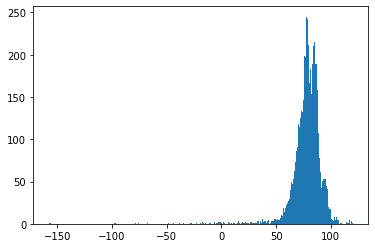

In [679]:
plt.hist(read_ease.values,bins = 300)
plt.show()

The readability scaling $R$ is very sparse with negative value. To reduce it we apply the following transformation $$R \longrightarrow \log (|max(R)| - R +1)$$
This also affects how we interpret the variable. Now the readability variable increases with complexity.

In [680]:
read_ease = read_ease.apply(lambda x: np.log(abs(read_ease.max()) - x + 1))

In [681]:
read_ease.sample(3)

1847533    3.592644
1772207    3.598134
1831646    3.203559
Name: text, dtype: float64

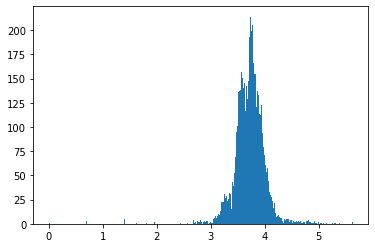

In [687]:
plt.hist(read_ease.values,bins = 300)
plt.show()

In [683]:
# For very complext texts : 
complex_tests = texts[read_ease > 5]

In [684]:
# How is tis complex : 
complex_tests.sample(2).values

array(['appearance- orange to amber brown, with nice white off colored thick head, lots of carbonation as lots of bubbles stream up the glass, mostly clear in bodySmell- very beautiful hops jump of the nose, citrus and piney hops, very great smell just so rich and full of hops you cant wait for your first sip, a heavy weight in the smell department,Taste- starts of with hints of malts and sugary sweetness, then absolutely smashes your palate with tons of hops so much so the finish is even overwhelmingly bitter, a bit of alcohol can definitely be noticed to me in the flavor, lacks a touch of balance in the flavor but does run the whole spectrum as starting a bit of malt, a bit of bitterness then some alcohol, i feel its weekness is the taste could have been more balanced and not one sided on the finishmouthfeel- warming for sure as you can feel the warmth of high alcohol in ur throat and mouth, its pretty thick and heavy bodied but still as touch of lightnessDrinkability- This is not a 

In [685]:
easy_texts = texts[read_ease < 2]

In [686]:
easy_texts.sample(2).values

array(['the best one so far. hope to age a few', 'It is what it is'],
      dtype=object)

This metric is based on how complex sentences are with the number of words and syllabers but does not focus on vocabulary. We can already see that it performs well based on the examples above. We should combine this feature with a vocabulary complexity based metric.

### We can try to evaluate complexity with grade year understanding scores of the reviews

In [688]:
dale = texts.apply(lambda x: textstat.dale_chall_readability_score(x))

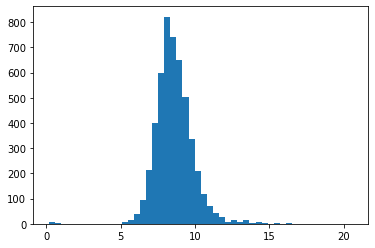

In [689]:
plt.hist(dale.values,bins = 50)
plt.show()

Skewed normal distribution like before. What are the reviews that have the best/lowest scores ?

In [690]:
dale_good = texts[dale > 14]

In [691]:
dale_good.sample(2).values

array(['Appearance: Pours a slightly hazy honey color with a fluffy head that hangs around for a while but sheets the chalice with a very nice patternSmell: This beer has the Saison aroma down to a tee, with a blend of herbaciousness, sweet candi sugar, mashed banana, grapefruit pith and a hint of funk; it could be a bit funkier, if I had my druthers, but it is fine as isTaste: The initial wheat bread and slightly sweet flavors give way, mid-palate, to the herbacious bitterness and grapefruit pith; after the swallow, the bitterness is mellowed by the sweeter elements, including pineapple and apricot, although the herbacious side hangs around for the durationMouthfeel: Light to medium body with spritzy carbonationDrinkability: Having just consumed a Red Barn, this kissing cousin has a tough precedent to live up to; I think I prefer the layered complexity of the Red Barn, but this is well suited to a warmer summer occasion - too bad we are in December, right now',
       ' bottling - bes

In [692]:
dale_bad = texts[dale < 6]

In [693]:
dale_bad.sample(2).values

array(["One of the best I've ever had. Thank you NEBCO",
       'It is what it is'], dtype=object)

## Now we try with TextBlob

In [699]:
#ctexts = texts.apply(lambda x: TextBlob(x).correct())

In [701]:
#ctexts[dale.idxmax()]

In [702]:
#ctexts[dale.idxmin()]

Clearly inefficient

### Combine two complexities

In [709]:
read_ease_norm =  (read_ease - read_ease.mean())/read_ease.std()

In [710]:
dale_norm = (dale - dale.mean())/dale.std()

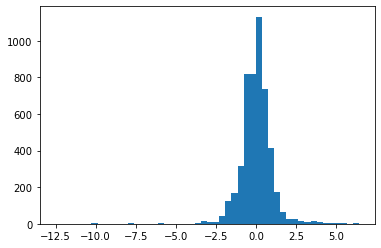

In [711]:
plt.hist(read_ease_norm.values,bins = 50)
plt.show()

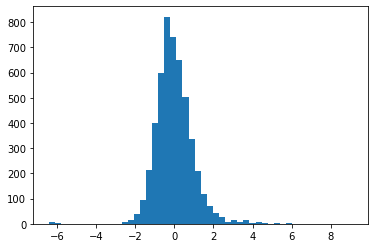

In [712]:
plt.hist(dale_norm.values,bins = 50)
plt.show()

In [716]:
complexity = dale_norm + read_ease_norm

In [717]:
complexity.head()

554354    -0.911961
1812376   -1.234639
1311971   -1.690129
100110     1.704103
2480729   -0.621680
Name: text, dtype: float64

<AxesSubplot:ylabel='Count'>

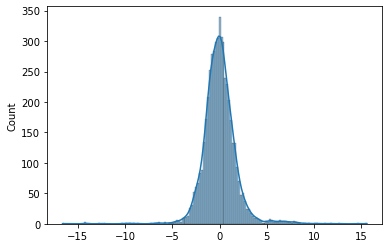

In [718]:
sns.histplot(data=complexity, x=complexity.values, kde=True)

## For the Machine learning algorithm 

In [ ]:
import pandas as pd
import numpy as np
import re
import textstat
from textblob import TextBlob
import matplotlib.pyplot as plt
from langdetect import detect
import seaborn as sns
from html.parser import HTMLParser

In [512]:
class HTMLTagsRemover(HTMLParser):
    def __init__(self):
        super().__init__(convert_charrefs=False)
        self.reset()
        self.convert_charrefs = True
        self.fed = []

    def handle_data(self, data):
        self.fed.append(data)

    def handle_entityref(self, name):
        self.fed.append(f'&{name};')

    def handle_charref(self, name):
        self.fed.append(f'&#{name};')

    def get_data(self):
        return ''.join(self.fed)


def remove_html_tags(value):
    remover = HTMLTagsRemover()

    remover.feed(value)
    remover.close()
    return remover.get_data()


def clean_reviews(df_old):
    df = df_old['text'].copy(deep=True) #not modify input dataframe
    
    df.dropna(inplace=True) #drop non-reviewers
    
    df = df[df.apply(lambda x: len(x) > 11)] # drop date reviews DD/MM/YYY
    
    df = df[df.apply(lambda x: detect(x) == 'en')] # We verify everything is in English
    
    return df
    
    

def complexity(df_old):
    texts = df_old['text'].copy(deep=True) #not modify input dataframe

    # Remove numbers ---> Useless for complexity of lexicon
    pattern = r'[0-9]'
    texts = texts.apply(lambda x : re.sub(pattern, '', x))
    
    # Remove HTML encoders
    texts = texts.apply(lambda x: remove_html_tags(x))
    
    # Computing the reading-ease complexity
    read_ease = texts.apply(lambda x: textstat.flesch_reading_ease(x))
    # And scale it properly
    read_ease = read_ease.apply(lambda x: np.log(abs(read_ease.max()) - x + 1))
    # Then, normalize
    read_ease =  (read_ease - read_ease.mean())/read_ease.std()
    
    # Computing the Dale–Chall readability complexity
    dale = texts.apply(lambda x: textstat.dale_chall_readability_score(x))
    # Does not need rescaling apparently. But normalized to account to the complexity the same way as read_ease
    dale = (dale - dale.mean())/dale.std()
    
    # Now the complexity
    complexity = dale_norm + read_ease_norm
    # That we normalize
    complexity = (complexity - complexity.mean())/complexity.std()
    
    return complexity
